In [19]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, models
from tensorflow.keras.applications import VGG16
from skimage import color
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

print("TensorFlow:", tf.__version__)
gpu = tf.config.list_physical_devices('GPU')
print("GPU:", gpu)


TensorFlow: 2.18.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 # 1. Hiperparámetros y config

In [32]:
# Dataset 
BASE_DATA_PATH = '/kaggle/input/stl10'

def find_subfolder(base, sub_name):
    for root, dirs, files in os.walk(base):
        if sub_name in dirs:
            return os.path.join(root, sub_name)
    return os.path.join(base, sub_name)

TRAIN_PATH_ROOT = find_subfolder(BASE_DATA_PATH, "unlabeled_images")
VAL_PATH_ROOT = find_subfolder(BASE_DATA_PATH, "train_images")
TEST_PATH_ROOT = find_subfolder(BASE_DATA_PATH, "test_images")

# Paths de las máscaras
MASK_BASE_DIR = "/kaggle/input/masks-stl10/masks"
TRAIN_MASK_PATH = os.path.join(MASK_BASE_DIR, "unlabeled_images")
VAL_MASK_PATH = os.path.join(MASK_BASE_DIR, "train_images")
TEST_MASK_PATH = os.path.join(MASK_BASE_DIR, "test_images")

IMG_SIZE = 128
BATCH_SIZE = 32
SEED = 42
LAMBDA = 10

# subsets
SUBSET_SIZE_TRAIN = 20000
SUBSET_SIZE_VAL = 1000
SUBSET_SIZE_TEST = 8000

# 2. Cargamos y procesamos los datos

In [33]:
NUM_CLASSES = 9

def load_npy(m_root, f_name):
    m_path = os.path.join(m_root.decode('utf-8'), f_name.decode('utf-8'))
    if os.path.exists(m_path):
        mask = np.load(m_path) 
    else:
        mask = np.zeros((IMG_SIZE, IMG_SIZE, NUM_CLASSES), dtype=np.float32)
    mask = mask.astype(np.float32)
        
    return mask

def load_image_and_mask(image_file, mask_root_path):
    # Cargamos imagenes
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    
    # Cargamos las máscaras
    parts = tf.strings.split(image_file, os.path.sep)
    file_name = parts[-1]
    mask_name = tf.strings.regex_replace(file_name, '.png', '.npy')

    mask = tf.numpy_function(load_npy, [mask_root_path, mask_name], tf.float32)
    mask.set_shape([IMG_SIZE, IMG_SIZE, NUM_CLASSES]) 

    return image, mask
    
def skimage_rgb2lab(x):
        lab = color.rgb2lab(x)
        return lab.astype(np.float32)
    
def rgb_to_lab(img_rgb):
    img_lab = tf.numpy_function(skimage_rgb2lab, [img_rgb], tf.float32)
    return img_lab

def lab_to_rgb(L, ab):
    L = (L + 1.0) * 50.0
    ab = ab * 128.0
    lab = np.concatenate([L, ab], axis=-1)
    return color.lab2rgb(lab)

def process_path(file_path, mask_root_path):
    img_rgb, mask = load_image_and_mask(file_path, mask_root_path)
    img_lab = rgb_to_lab(img_rgb)
    L = img_lab[:, :, 0:1] / 50.0 - 1.0
    ab = img_lab[:, :, 1:] / 128.0
    return L, mask, ab

# Creamos los datasets 
train_files = sorted(glob(os.path.join(TRAIN_PATH_ROOT, "*.png")))[:SUBSET_SIZE_TRAIN]
val_files = sorted(glob(os.path.join(VAL_PATH_ROOT, "*.png")))[:SUBSET_SIZE_VAL]
test_files = sorted(glob(os.path.join(TEST_PATH_ROOT, "*.png")))[:SUBSET_SIZE_TEST]

train_ds = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_ds.map(lambda x: process_path(x, TRAIN_MASK_PATH), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(2048, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(val_files)
val_ds = val_ds.map(lambda x: process_path(x, VAL_MASK_PATH), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(test_files)
test_ds = test_ds.map(lambda x: process_path(x, TEST_MASK_PATH), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator(input_shape=(IMG_SIZE, IMG_SIZE, 10)):
    inputs = layers.Input(shape=input_shape)

    # Encoder 
    down_fases = [
        downsample(64, 4, apply_batchnorm=False), 
        downsample(128, 4),                        
        downsample(256, 4),                        
        downsample(512, 4),                        
        downsample(512, 4),                        
    ]

    # Decoder 
    up_fases = [
        upsample(512, 4, apply_dropout=True),      
        upsample(512, 4, apply_dropout=True),      
        upsample(256, 4),                          
        upsample(128, 4),                          
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(2, 4, strides=2, padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 

    x = inputs
    skips = []
    
    # Encoder 
    for down in down_fases:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Decoder 
    for up, skip in zip(up_fases, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return models.Model(inputs=inputs, outputs=x)


generator = Generator()
generator.summary()

Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_42       │ (None, 64, 64,    │     10,240 │ input_layer_46[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_43       │ (None, 32, 32,    │    131,584 │ sequential_42[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_44       │ (None, 16, 16,    │    525,312 │ sequential_43[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_45       │ (None, 8, 8, 512) │  2,099,200 │ sequential_44[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_46       │ (None, 4, 4, 512) │  4,196,352 │ sequential_45[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_47       │ (None, 8, 8, 512) │  4,196,352 │ sequential_46[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 8, 8,      │          0 │ sequential_47[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_45[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_48       │ (None, 16, 16,    │  8,390,656 │ concatenate_33[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_34      │ (None, 16, 16,    │          0 │ sequential_48[0]… │
│ (Concatenate)       │ 768)              │            │ sequential_44[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_49       │ (None, 32, 32,    │  3,146,752 │ concatenate_34[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_35      │ (None, 32, 32,    │          0 │ sequential_49[0]… │
│ (Concatenate)       │ 384)              │            │ sequential_43[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_50       │ (None, 64, 64,    │    786,944 │ concatenate_35[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (None, 64, 64,    │          0 │ sequential_50[0]… │
│ (Concatenate)       │ 192)              │            │ sequential_42[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_24 │ (None, 128, 128,  │      6,146 │ concatenate_36[0… │
│ (Conv2DTranspose)   │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,489,538 (89.61 MB)

 Trainable params: 23,483,906 (89.58 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [21]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 10], name="input_im")
    tar = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 2], name="target_im")

    x = layers.Concatenate()([inp, tar])

    # features
    down1 = downsample(64, 4, False)(x)     # feature 1
    down2 = downsample(128, 4)(down1)       # feature 2
    down3 = downsample(256, 4)(down2)       # feature 3

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    # devuelve la salida y features
    return Model(
        inputs=[inp, tar],
        outputs=[last, [down1, down2, down3, leaky_relu]]
    )

discriminator = Discriminator()
discriminator.summary()

Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_im            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_im           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_37      │ (None, 128, 128,  │          0 │ input_im[0][0],   │
│ (Concatenate)       │ 12)               │            │ target_im[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_51       │ (None, 64, 64,    │     12,288 │ concatenate_37[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_52       │ (None, 32, 32,    │    131,584 │ sequential_51[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_53       │ (None, 16, 16,    │    525,312 │ sequential_52[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 18, 18,    │          0 │ sequential_53[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 15, 15,    │  2,097,152 │ zero_padding2d_4… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      2,048 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_36      │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 17, 17,    │          0 │ leaky_re_lu_36[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 14, 14, 1) │      8,193 │ zero_padding2d_5… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,776,577 (10.59 MB)

 Trainable params: 2,774,785 (10.58 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [22]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def feature_matching_loss(real_feats, fake_feats):
    loss = 0
    for fr, fg in zip(real_feats, fake_feats):
        loss += tf.reduce_mean(tf.abs(fr - fg))
    return loss

def generator_loss(disc_generated_output, gen_output, target,real_feats, fake_feats):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss  = tf.reduce_mean(tf.abs(target - gen_output))
    fm_loss  = feature_matching_loss(real_feats, fake_feats)

    total_gen_loss = gan_loss + (LAMBDA * l1_loss) + (LAMBDA * fm_loss)

    return total_gen_loss, gan_loss, l1_loss, fm_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss


generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
@tf.function
def train_step(L, mask, target_ab):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        inputs = tf.concat([L, mask], axis=-1)

        gen_output = generator(inputs, training=True)
        disc_real_out, real_feats = discriminator([inputs, target_ab], training=True)
        disc_fake_out, fake_feats = discriminator([inputs, gen_output], training=True)
        
        # loss generador, gan + f1 + fm
        gen_total_loss, gan_loss, l1_loss, fm_loss = generator_loss(
            disc_fake_out, gen_output, target_ab, real_feats, fake_feats
        )

        # loss discriminador
        disc_loss = discriminator_loss(disc_real_out, disc_fake_out)

    gen_grads = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_total_loss, disc_loss

def generate_images(model, test_input_L, test_input_mask, tar):
    input_combined = tf.concat([test_input_L, test_input_mask], axis=-1)
    prediction = model(input_combined, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [
        lab_to_rgb(test_input_L[0].numpy(), tar[0].numpy()),
        lab_to_rgb(test_input_L[0].numpy(), prediction[0].numpy())
    ]
    title = ['Real', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

def train(train_ds, epochs, val_ds):
    for epoch in range(epochs):
        start = time.time()
        gen_losses, disc_losses = [], []

        for L, mask, ab in tqdm(train_ds, desc=f"Epoch {epoch+1}/{epochs}"):
            gen_loss, disc_loss = train_step(L, mask, ab)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        print(f"Epoch {epoch+1} Loss - G: {np.mean(gen_losses):.4f}, D: {np.mean(disc_losses):.4f}")


        if (epoch + 1) % 5 == 0:
            for ex_L, ex_mask, ex_ab in val_ds.take(1):
                generate_images(generator, ex_L, ex_mask, ex_ab)


Epoch 1/50:   0%|          | 0/313 [00:00<?, ?it/s]E0000 00:00:1765560602.136769      47 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_56_1/sequential_47_1/dropout_8_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1765560603.223774      88 cuda_dnn.cc:529] Loaded cuDNN version 90300
Epoch 1/50: 100%|██████████| 313/313 [02:21<00:00,  2.21it/s]


Epoch 1 Loss - G: 11.3731, D: 1.1511


Epoch 2/50: 100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


Epoch 2 Loss - G: 13.7188, D: 1.0450


Epoch 3/50: 100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


Epoch 3 Loss - G: 13.9599, D: 1.1206


Epoch 4/50: 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch 4 Loss - G: 14.0831, D: 1.1475


Epoch 5/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 5 Loss - G: 13.9858, D: 1.1620


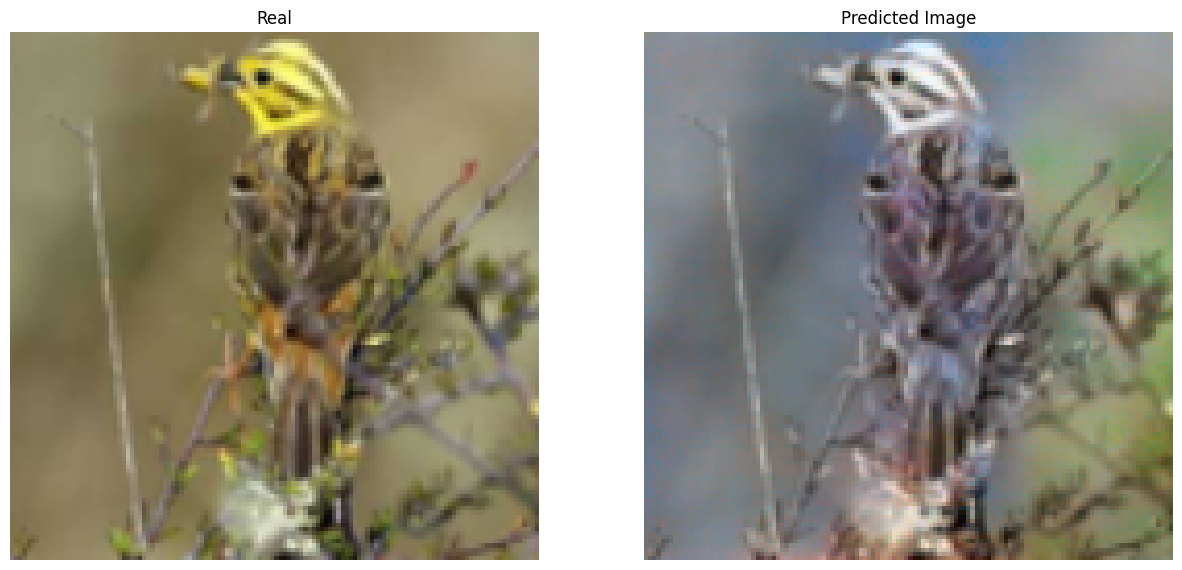

Epoch 6/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 6 Loss - G: 13.8211, D: 1.1618


Epoch 7/50: 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch 7 Loss - G: 13.7343, D: 1.1526


Epoch 8/50: 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch 8 Loss - G: 13.6217, D: 1.1654


Epoch 9/50: 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch 9 Loss - G: 13.4020, D: 1.1626


Epoch 10/50: 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch 10 Loss - G: 13.2828, D: 1.1689


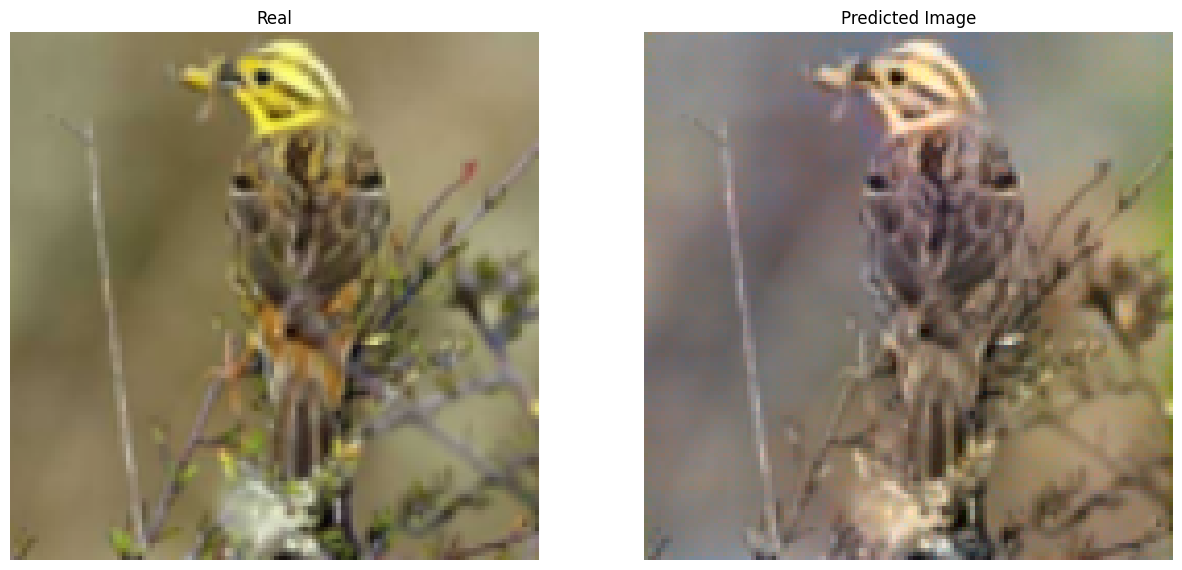

Epoch 11/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 11 Loss - G: 13.1866, D: 1.1730


Epoch 12/50: 100%|██████████| 313/313 [02:02<00:00,  2.54it/s]


Epoch 12 Loss - G: 13.0308, D: 1.1640


Epoch 13/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 13 Loss - G: 12.9001, D: 1.1639


Epoch 14/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 14 Loss - G: 12.7348, D: 1.1702


Epoch 15/50: 100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


Epoch 15 Loss - G: 12.6090, D: 1.1569


/tmp/ipykernel_47/481827212.py:48: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  return color.lab2rgb(lab)


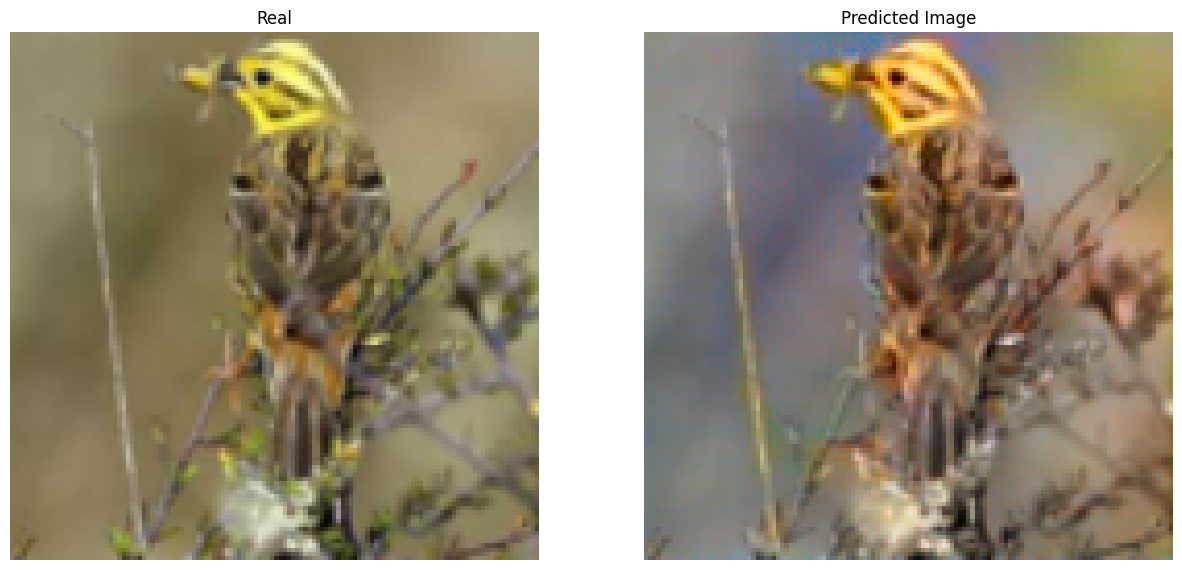

Epoch 16/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 16 Loss - G: 12.4445, D: 1.1542


Epoch 17/50: 100%|██████████| 313/313 [02:02<00:00,  2.54it/s]


Epoch 17 Loss - G: 12.2789, D: 1.1317


Epoch 18/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 18 Loss - G: 12.1016, D: 1.1364


Epoch 19/50: 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch 19 Loss - G: 11.9511, D: 1.1025


Epoch 20/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 20 Loss - G: 11.8749, D: 1.0980


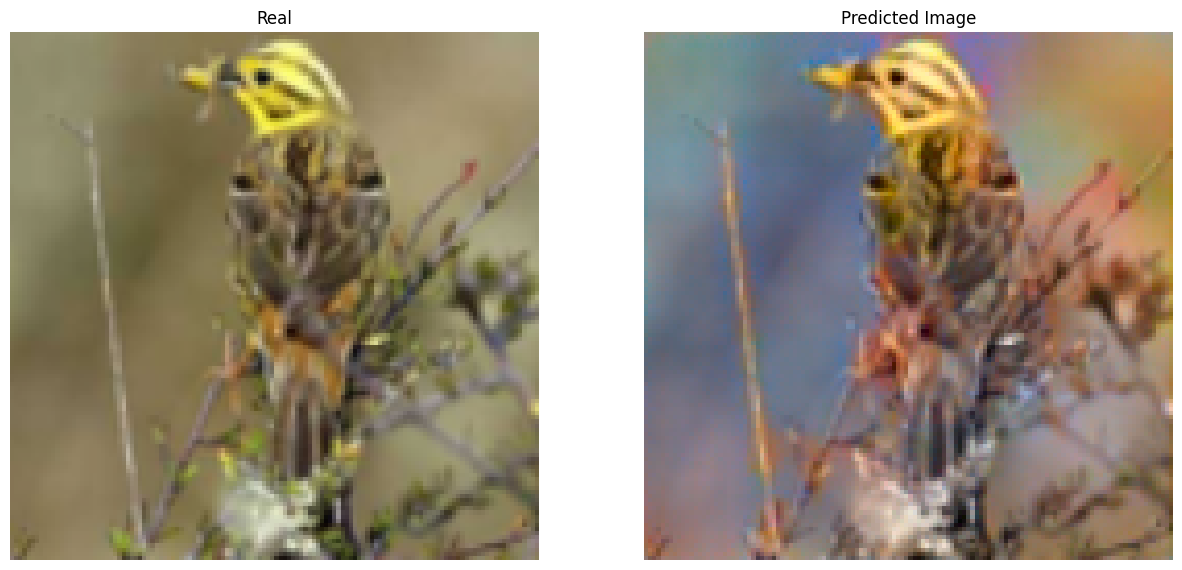

Epoch 21/50: 100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


Epoch 21 Loss - G: 11.5833, D: 1.1122


Epoch 22/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 22 Loss - G: 11.4228, D: 1.1188


Epoch 23/50: 100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


Epoch 23 Loss - G: 11.3148, D: 1.0969


Epoch 24/50: 100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


Epoch 24 Loss - G: 11.1345, D: 1.1219


Epoch 25/50: 100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


Epoch 25 Loss - G: 11.0199, D: 1.1231


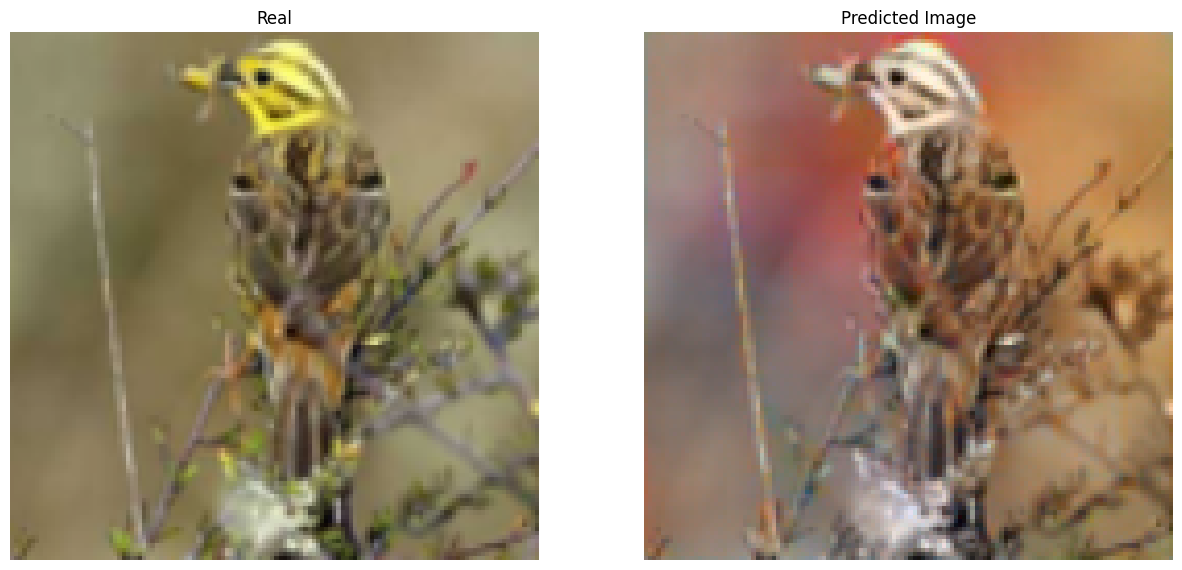

Epoch 26/50: 100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


Epoch 26 Loss - G: 10.9493, D: 1.0941


Epoch 27/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 27 Loss - G: 10.8101, D: 1.1279


Epoch 28/50: 100%|██████████| 313/313 [02:07<00:00,  2.45it/s]


Epoch 28 Loss - G: 10.6635, D: 1.1198


Epoch 29/50: 100%|██████████| 313/313 [02:05<00:00,  2.50it/s]


Epoch 29 Loss - G: 10.5884, D: 1.1497


Epoch 30/50: 100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


Epoch 30 Loss - G: 10.4730, D: 1.1297


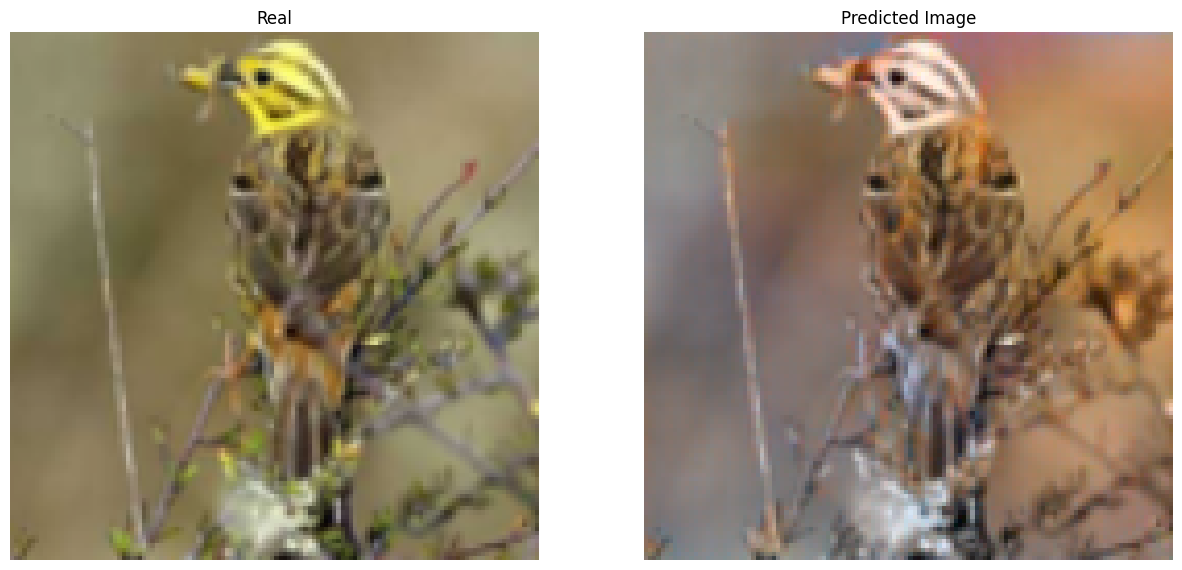

Epoch 31/50: 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch 31 Loss - G: 10.4063, D: 1.1171


Epoch 32/50: 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch 32 Loss - G: 10.3208, D: 1.1146


Epoch 33/50: 100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


Epoch 33 Loss - G: 10.2538, D: 1.1310


Epoch 34/50: 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch 34 Loss - G: 10.1235, D: 1.1399


Epoch 35/50: 100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


Epoch 35 Loss - G: 10.0539, D: 1.1315


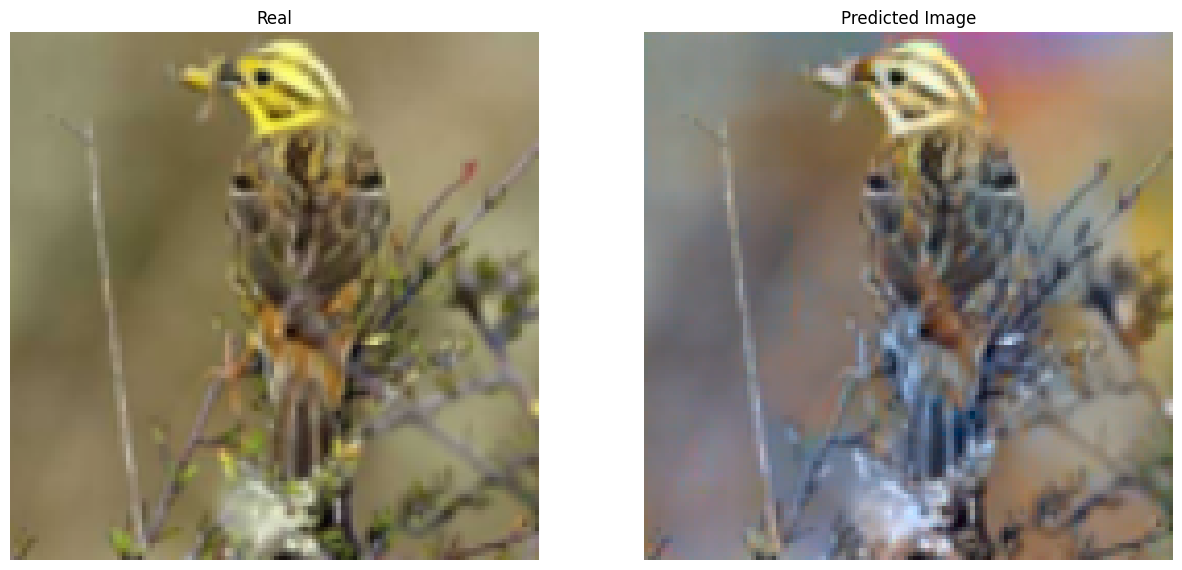

Epoch 36/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 36 Loss - G: 9.9565, D: 1.1485


Epoch 37/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 37 Loss - G: 9.8563, D: 1.1875


Epoch 38/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 38 Loss - G: 9.7814, D: 1.1263


Epoch 39/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 39 Loss - G: 9.7291, D: 1.1440


Epoch 40/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 40 Loss - G: 9.6722, D: 1.1284


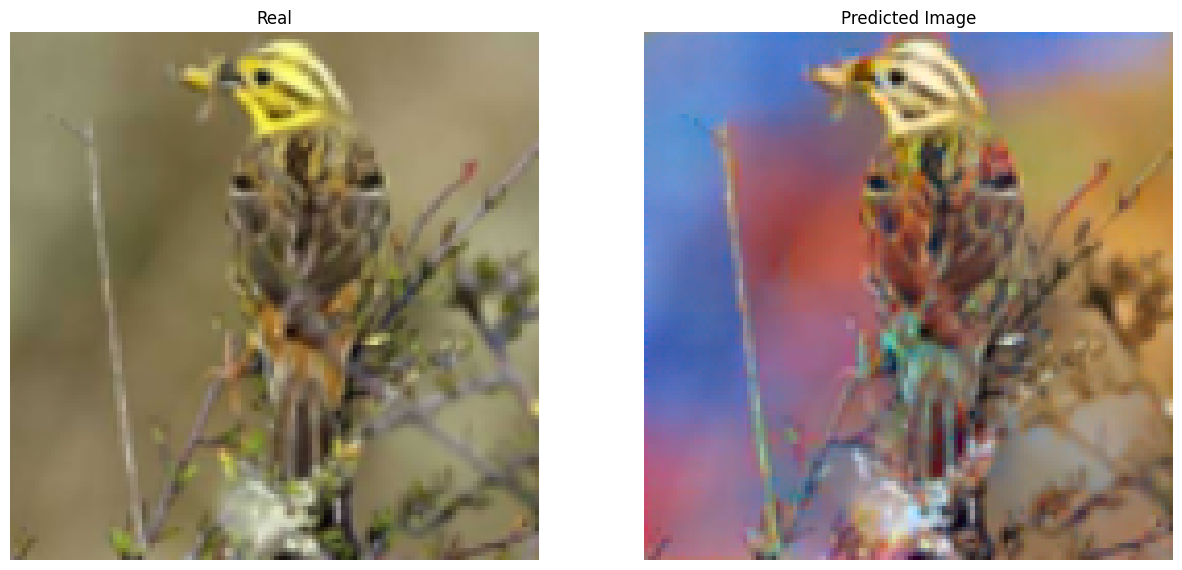

Epoch 41/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 41 Loss - G: 9.5842, D: 1.1607


Epoch 42/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 42 Loss - G: 9.4689, D: 1.2463


Epoch 43/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 43 Loss - G: 9.4431, D: 1.1316


Epoch 44/50: 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch 44 Loss - G: 9.4394, D: 1.1451


Epoch 45/50: 100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


Epoch 45 Loss - G: 9.3773, D: 1.1370


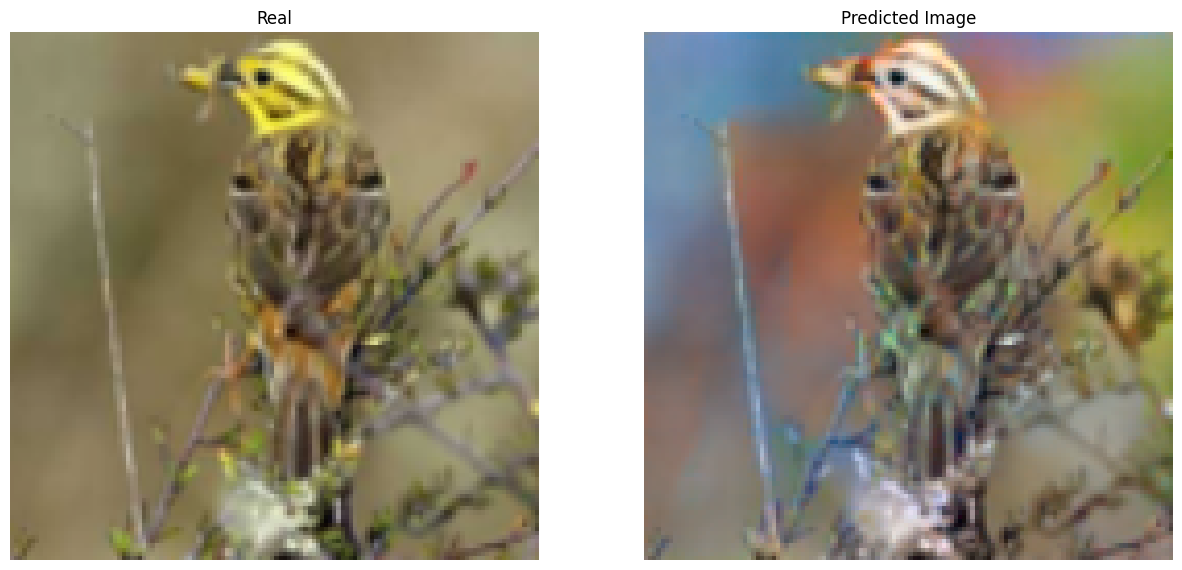

Epoch 46/50: 100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


Epoch 46 Loss - G: 9.2847, D: 1.1827


Epoch 47/50: 100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


Epoch 47 Loss - G: 9.2342, D: 1.1334


Epoch 48/50: 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 48 Loss - G: 9.1333, D: 1.2182


Epoch 49/50: 100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


Epoch 49 Loss - G: 9.1456, D: 1.1416


Epoch 50/50: 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch 50 Loss - G: 9.0214, D: 1.2391


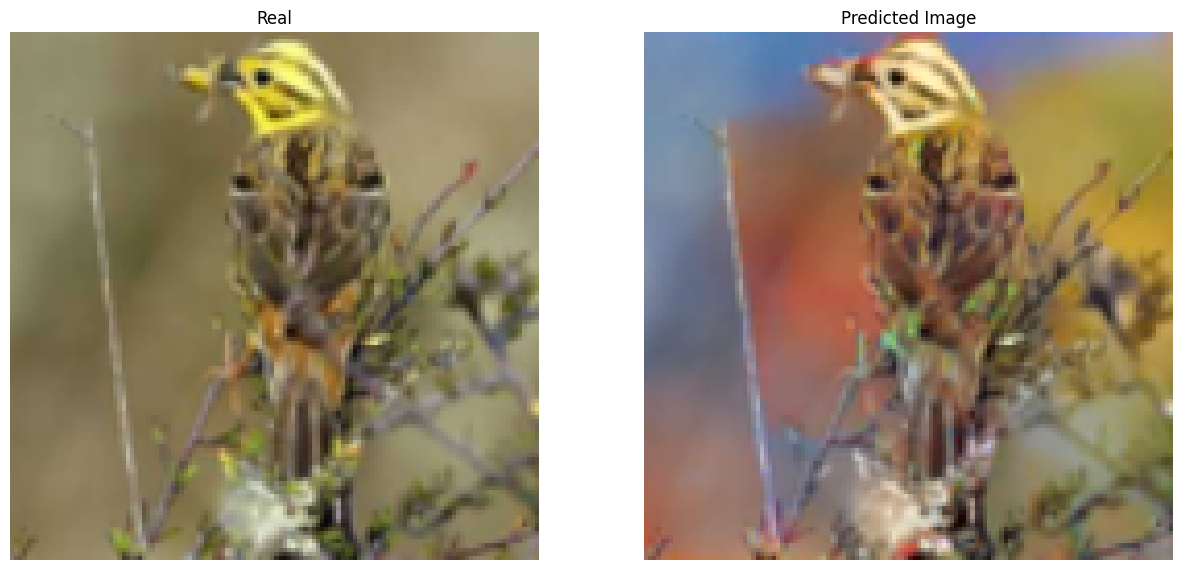

In [25]:
train(train_ds, 50, val_ds)

In [26]:
generator.save('semantic_gan_generator.keras')

In [29]:
import lpips
import torch
# LPIPS
device_torch = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_model = lpips.LPIPS(net='alex').to(device_torch)
lpips_model.eval()

def compute_lpips_torch(img1, img2):

    # Convert to Tensor
    t1 = torch.tensor(img1).permute(2,0,1).unsqueeze(0).float()
    t2 = torch.tensor(img2).permute(2,0,1).unsqueeze(0).float()

    # Normalize to [-1,1]
    t1 = t1 * 2 - 1
    t2 = t2 * 2 - 1

    # Move to device
    t1 = t1.to(device_torch)
    t2 = t2.to(device_torch)

    with torch.no_grad():
        dist = lpips_model(t1, t2)

    return dist.item()


def evaluate_model(model, ds, num_samples=10):
    ssim_scores = []
    psnr_scores = []
    lpips_scores = []

    count = 0
    for batch in tqdm(ds):
        if len(batch) == 2:
            L, ab = batch
            mask = tf.zeros((L.shape[0], IMG_SIZE, IMG_SIZE, 9), tf.float32)
        else:
            L, mask, ab = batch  

        # Entrada
        inp = tf.concat([L, mask], axis=-1)

        # Predicción
        preds = model(inp, training=False)

        # Métricas
        for i in range(L.shape[0]):
            if num_samples and count >= num_samples:
                break

            real_rgb = lab_to_rgb(L[i].numpy(), ab[i].numpy())
            pred_rgb = lab_to_rgb(L[i].numpy(), preds[i].numpy())

            real_t = tf.expand_dims(real_rgb, 0)
            pred_t = tf.expand_dims(pred_rgb, 0)

            # SSIM PSNR
            ssim_scores.append(float(tf.image.ssim(real_t, pred_t, max_val=1.0).numpy()[0]))
            psnr_scores.append(float(tf.image.psnr(real_t, pred_t, max_val=1.0).numpy()[0]))

            # LPIPS
            lp = compute_lpips_torch(real_rgb, pred_rgb)
            lpips_scores.append(lp)

            count += 1

        if num_samples and count >= num_samples:
            break

    print(f"SSIM:  {np.mean(ssim_scores):.4f}")
    print(f"PSNR:  {np.mean(psnr_scores):.4f}")
    print(f"LPIPS: {np.mean(lpips_scores):.4f}")

    return np.mean(ssim_scores), np.mean(psnr_scores), np.mean(lpips_scores)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 219MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [30]:
ssim, psnr, lpips = evaluate_model(generator,test_ds,8000)

  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_47/481827212.py:48: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  return color.lab2rgb(lab)
  4%|▍         | 5/125 [00:11<04:29,  2.25s/it]/tmp/ipykernel_47/481827212.py:48: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  return color.lab2rgb(lab)
 13%|█▎        | 16/125 [00:35<03:55,  2.16s/it]/tmp/ipykernel_47/481827212.py:48: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  return color.lab2rgb(lab)
 14%|█▍        | 18/125 [00:39<03:52,  2.18s/it]/tmp/ipykernel_47/481827212.py:48: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 13 negative Z values that have been clipped to zero
  return color.lab2rgb(lab)
 31%|███       | 39/125 [01:24<03:02,  2.12s/it]/

SSIM:  0.9073
PSNR:  23.3946
LPIPS: 0.1660


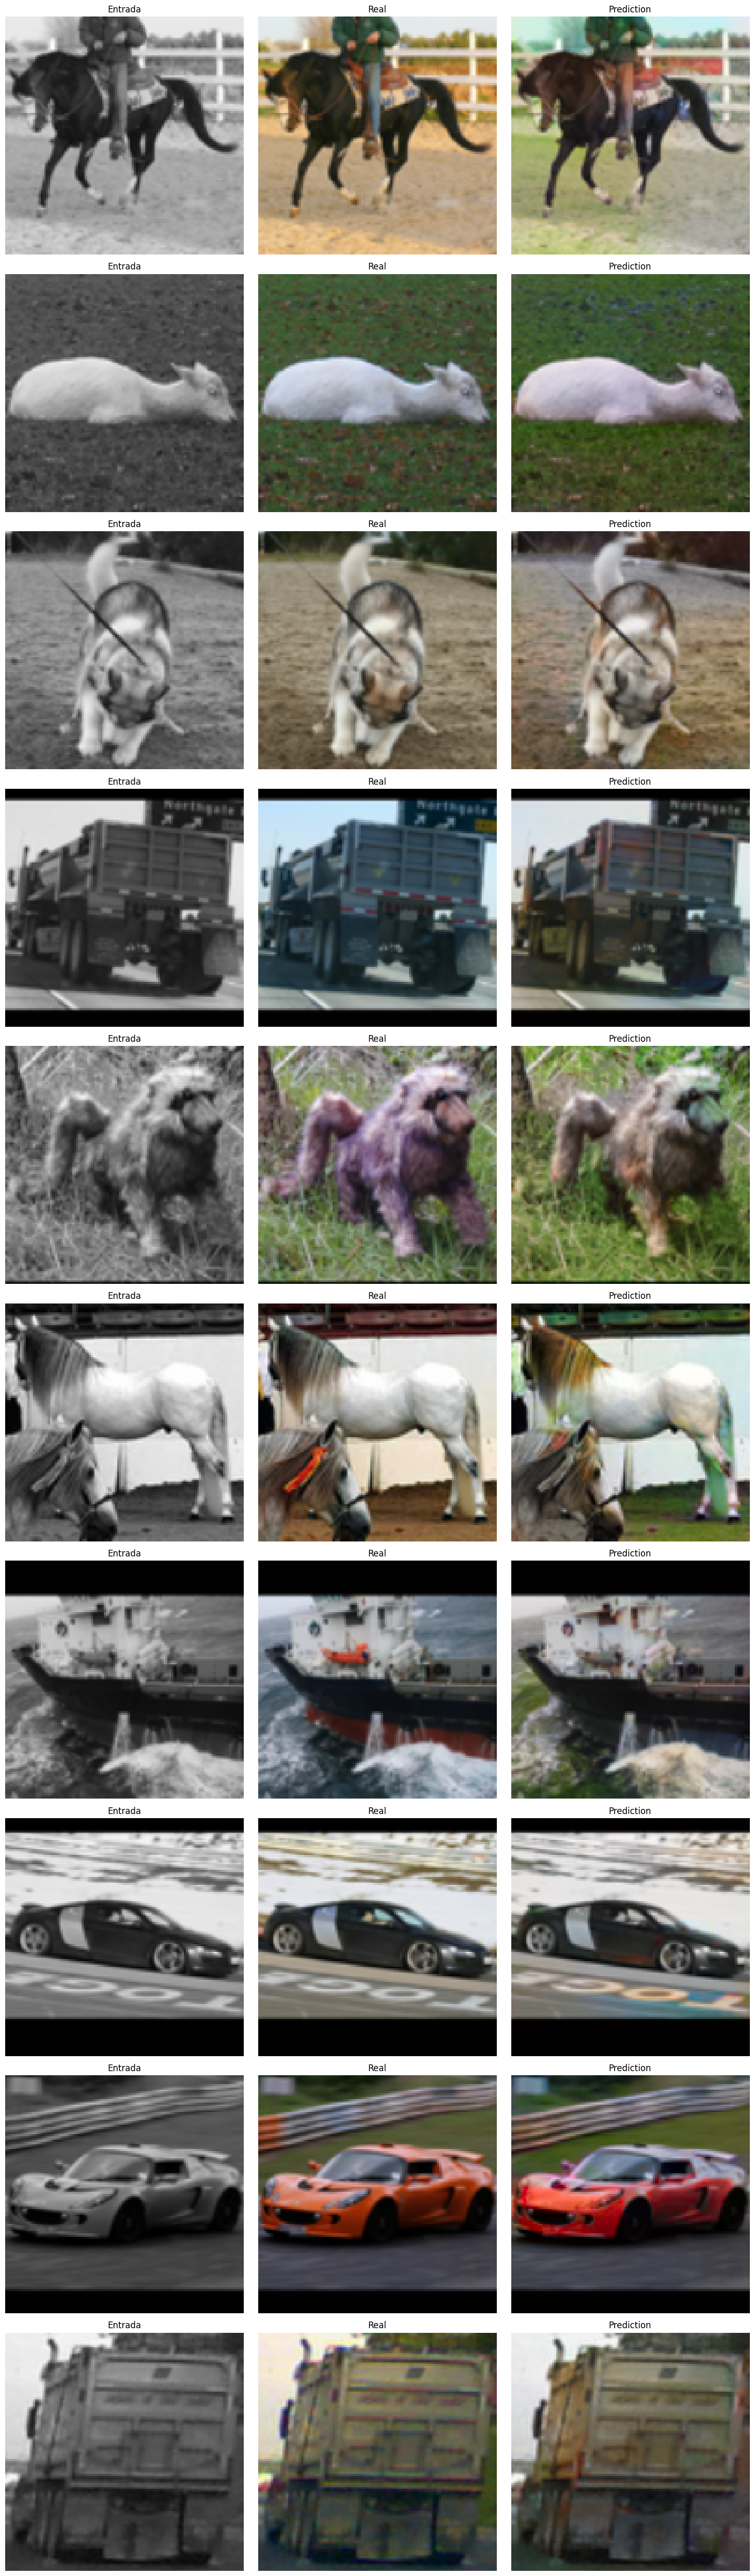

In [43]:
# Ejemplos
def show_examples(model, ds, num=10):
    plt.figure(figsize=(15, 5*num))

    batch = next(iter(ds.take(1)))
    L_batch, mask_batch, ab_batch = batch

    model_input = tf.concat([L_batch, mask_batch], axis=-1)

    preds_batch = model(model_input, training=False)

    for i in range(num):
        idx = i if i < L_batch.shape[0] else np.random.randint(0, L_batch.shape[0])

        real = lab_to_rgb(L_batch[idx].numpy(), ab_batch[idx].numpy())
        pred = lab_to_rgb(L_batch[idx].numpy(), preds_batch[idx].numpy())
        gray = lab_to_rgb(L_batch[idx].numpy(), np.zeros_like(ab_batch[idx].numpy()))

        plt.subplot(num, 3, i*3 + 1)
        plt.imshow(gray)
        plt.title("Entrada")
        plt.axis('off')

        plt.subplot(num, 3, i*3 + 2)
        plt.imshow(real)
        plt.title("Real")
        plt.axis('off')

        plt.subplot(num, 3, i*3 + 3)
        plt.imshow(pred)
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_examples(generator, test_ds, num=10)